In [64]:
from utils.data_generated import *
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS

In [65]:
#load panda dataframes for movies, poeple, and cluster
movies = load_movie_metadata()
people = load_people()
cluster = load_cluster_optics()
ethnicities = load_ethnicities()

In [69]:
#transfomr dict cluster into dataframe, index is the cluster key and the corresponding value is the cluster value, with columns names person_name_id and cluster_id
cluster_df = pd.DataFrame.from_dict(cluster, orient='index', columns=['cluster_id'])
#name the index column
cluster_df.index.name = 'person_name_id'

#print number of clusters
print("Number of clusters: ", len(cluster_df.cluster_id.unique()))

Number of clusters:  6


There are a total of 6 clusters, 1 is the clusters of the outliers (with value -1).

In [70]:
#create panda dataframe on all custer_id == i, take corresponding person from people matching on person_name_id 
cluster1 = cluster_df[cluster_df['cluster_id'] == 0].join(people.set_index('person_name_id'))
cluster2 = cluster_df[cluster_df['cluster_id'] == 1].join(people.set_index('person_name_id'))
cluster3 = cluster_df[cluster_df['cluster_id'] == 2].join(people.set_index('person_name_id'))
cluster4 = cluster_df[cluster_df['cluster_id'] == 3].join(people.set_index('person_name_id'))
cluster5 = cluster_df[cluster_df['cluster_id'] == 4].join(people.set_index('person_name_id'))
cluster_outlier = cluster_df[cluster_df['cluster_id'] == -1].join(people.set_index('person_name_id'))


In [71]:
#print the number of people in each cluster
print('number of people in cluster 1: ', len(cluster1))
print('number of people in cluster 2: ', len(cluster2))
print('number of people in cluster 3: ', len(cluster3))
print('number of people in cluster 4: ', len(cluster4))
print('number of people in cluster 5: ', len(cluster5))
print('number of people in cluster outlier: ', len(cluster_outlier))

number of people in cluster 1:  25417
number of people in cluster 2:  2324
number of people in cluster 3:  1219
number of people in cluster 4:  1140
number of people in cluster 5:  3341
number of people in cluster outlier:  38299


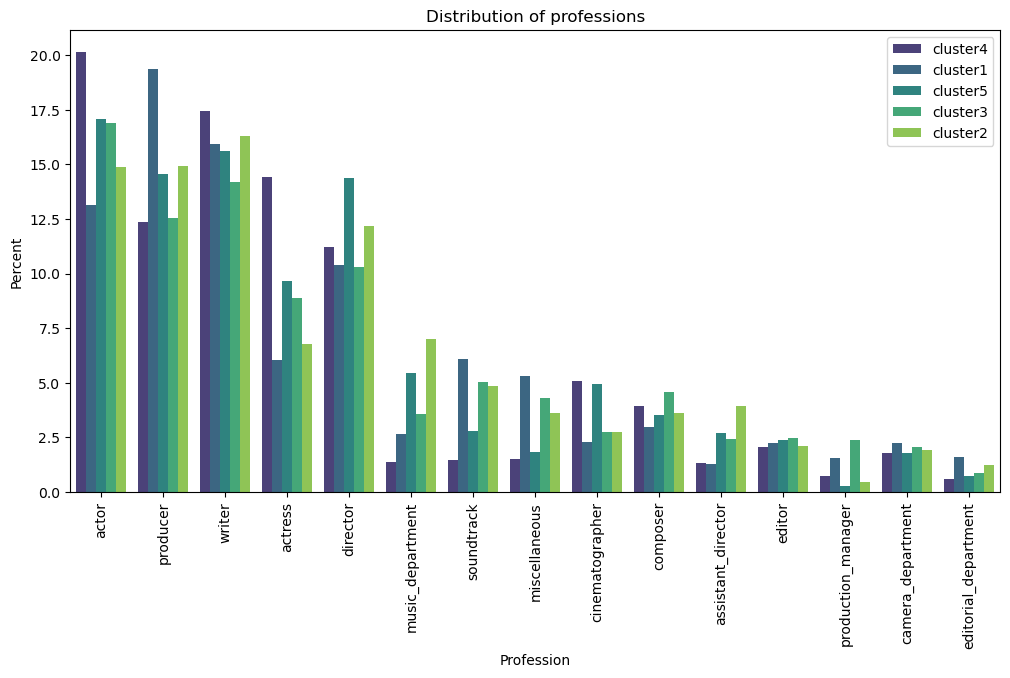

In [80]:
cluster1_jobs = pd.DataFrame([j for l in cluster1.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_jobs = pd.DataFrame([j for l in cluster2.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_jobs = pd.DataFrame([j for l in cluster3.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_jobs = pd.DataFrame([j for l in cluster4.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_jobs = pd.DataFrame([j for l in cluster5.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()



cluster1_jobs['Cluster'] = 'cluster1'
cluster2_jobs['Cluster'] = 'cluster2'
cluster3_jobs['Cluster'] = 'cluster3'
cluster4_jobs['Cluster'] = 'cluster4'
cluster5_jobs['Cluster'] = 'cluster5'


# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_jobs, cluster2_jobs, cluster3_jobs, cluster4_jobs, cluster5_jobs]).sort_values(by='Percent', ascending=False)
agg = data.groupby(['Profession']).sum().sort_values(by=['Percent'], ascending=False)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['Profession'].isin(agg.index)]
sns.barplot(data=data, x='Profession', y='Percent', hue='Cluster', palette='viridis')


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of professions")
plt.xticks(rotation=90)

# plt.savefig(RESULTS_PATH + 'outliers_professions_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

Check for misclassification of actress and actor to gender M and F

In [125]:
#get entries in people taht have entry F for 'gender' and actor for 'primary_profession'
f = people[['gender', 'primary_profession']].dropna()
#drop all entries that are not actress
f = f[['actress' in x for x in f['primary_profession']]]
f = f[f['gender'] == 'M']
len(f)

34

In [126]:
#get entries in people taht have entry F for 'gender' and actor for 'primary_profession'
m = people[['gender', 'primary_profession']].dropna()
#drop all entries that are not actress
m = m[['actor' in x for x in m['primary_profession']]]
m = m[m['gender'] == 'F']
len(m)

44

### Movie genres

In [72]:
#get all titles of movies in cluster 1 from columns known_for_titles. each entry is a list of titles. save all titles in a list, removing duplicates
def get_titles(cluster):
    titles_cluster = set()
    for i in range(len(cluster)):
        if type(cluster.iloc[i].known_for_titles) == list:
            for title in cluster.iloc[i].known_for_titles:
                titles_cluster.add(title)

    #make it a dataframe
    return pd.DataFrame(list(titles_cluster), columns=['title'])


In [73]:
titles_cluster1 = get_titles(cluster1)
titles_cluster2 = get_titles(cluster2)
titles_cluster3 = get_titles(cluster3)
titles_cluster4 = get_titles(cluster4)
titles_cluster5 = get_titles(cluster5)

In [74]:
#keep only movies that are in the cluster 1
movies_cluster1 = movies[movies['title_id_imdb'].isin(titles_cluster1['title'])]
movies_cluster2 = movies[movies['title_id_imdb'].isin(titles_cluster2['title'])]
movies_cluster3 = movies[movies['title_id_imdb'].isin(titles_cluster3['title'])]
movies_cluster4 = movies[movies['title_id_imdb'].isin(titles_cluster4['title'])]
movies_cluster5 = movies[movies['title_id_imdb'].isin(titles_cluster5['title'])]


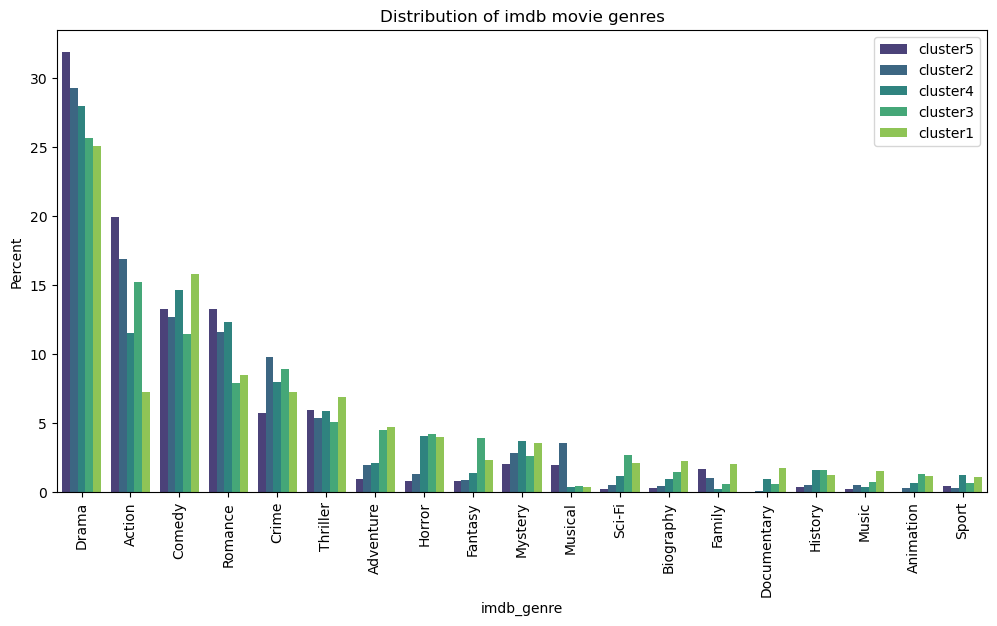

In [81]:
cluster1_imdb_genres = pd.DataFrame([j for l in movies_cluster1.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_imdb_genres = pd.DataFrame([j for l in movies_cluster2.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_imdb_genres = pd.DataFrame([j for l in movies_cluster3.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_imdb_genres = pd.DataFrame([j for l in movies_cluster4.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_imdb_genres = pd.DataFrame([j for l in movies_cluster5.genres_imdb.dropna().values for j in l], columns=['imdb_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()



cluster1_imdb_genres['Cluster'] = 'cluster1'
cluster2_imdb_genres['Cluster'] = 'cluster2'
cluster3_imdb_genres['Cluster'] = 'cluster3'
cluster4_imdb_genres['Cluster'] = 'cluster4'
cluster5_imdb_genres['Cluster'] = 'cluster5'


# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_imdb_genres, cluster2_imdb_genres, cluster3_imdb_genres, cluster4_imdb_genres, cluster5_imdb_genres]).sort_values(by='Percent', ascending=False)
agg = data.groupby(['imdb_genre']).sum().sort_values(by=['Percent'], ascending=False)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['imdb_genre'].isin(agg.index)]
sns.barplot(data=data, x='imdb_genre', y='Percent', hue='Cluster', palette='viridis')


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of imdb movie genres")
plt.xticks(rotation=90)

# plt.savefig(RESULTS_PATH + 'outliers_professions_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

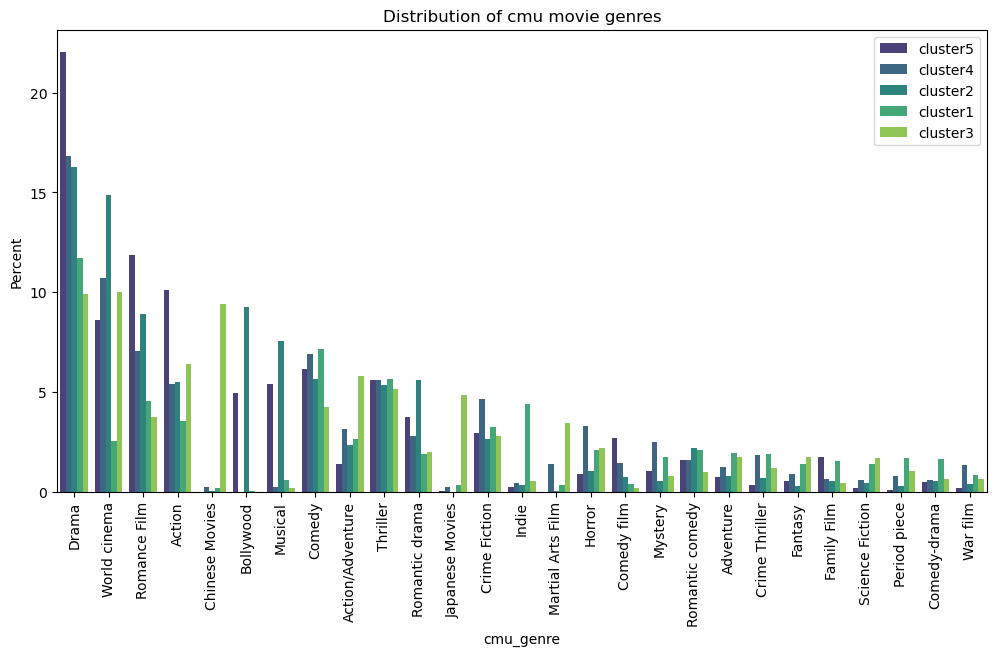

In [82]:
cluster1_imdb_genres = pd.DataFrame([j for l in movies_cluster1.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_imdb_genres = pd.DataFrame([j for l in movies_cluster2.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_imdb_genres = pd.DataFrame([j for l in movies_cluster3.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_imdb_genres = pd.DataFrame([j for l in movies_cluster4.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_imdb_genres = pd.DataFrame([j for l in movies_cluster5.genres_cmu.dropna().values for j in l], columns=['cmu_genre']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()



cluster1_imdb_genres['Cluster'] = 'cluster1'
cluster2_imdb_genres['Cluster'] = 'cluster2'
cluster3_imdb_genres['Cluster'] = 'cluster3'
cluster4_imdb_genres['Cluster'] = 'cluster4'
cluster5_imdb_genres['Cluster'] = 'cluster5'


# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_imdb_genres, cluster2_imdb_genres, cluster3_imdb_genres, cluster4_imdb_genres, cluster5_imdb_genres]).sort_values(by='Percent', ascending=False)
agg = data.groupby(['cmu_genre']).sum().sort_values(by=['Percent'], ascending=False)
agg.drop(agg[agg['Percent'] < 3].index, inplace=True)
data = data[data['cmu_genre'].isin(agg.index)]
sns.barplot(data=data, x='cmu_genre', y='Percent', hue='Cluster', palette='viridis')


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of cmu movie genres")
plt.xticks(rotation=90)

# plt.savefig(RESULTS_PATH + 'outliers_professions_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

### Ethnicity

In [76]:
#add column to ethnicites with name occurences
def get_ethnicities(cluster):
	e = ethnicities.copy()
	e['occurences'] = 0
	for ethnicity in people['ethnicity'].unique():
		#count occurence of ethnicit in cluster1
		count = len(cluster[cluster['ethnicity'] == ethnicity])
		e.loc[e['freebase_id'] == ethnicity, 'occurences'] = count
	e.drop(['freebase_id'], axis=1, inplace=True)
	#e.dropna(inplace=True)
	e.drop(e[e['occurences'] == 0].index, inplace=True)
	e.sort_values(by=['occurences'], ascending=False, inplace=True)
	return e


In [77]:
ethnicities1 = get_ethnicities(cluster1)
ethnicities2 = get_ethnicities(cluster2)
ethnicities3 = get_ethnicities(cluster3)
ethnicities4 = get_ethnicities(cluster4)
ethnicities5 = get_ethnicities(cluster5)	

In [83]:
#plot ethnicities 1 ditribution
def plot_eth(*args):
    for (eth, id) in args:
        #print(eth, id)
        eth = eth.copy()
        eth = eth[eth['occurences'] > 0]
        #keep only 10 most occuring, drop the rest
        num = eth.shape[0]
        if num > 20:
            num = 20
        eth = eth[:num]
        #get name of variable eth
        x = eth['ethnicity']
        y = eth['occurences']
        
        title = '{} most represneted ethnicities in cluster {}'.format(num, id)
        eth.plot.bar(x='ethnicity', y='occurences', rot=90, figsize=(20,10), title=title)



    
 

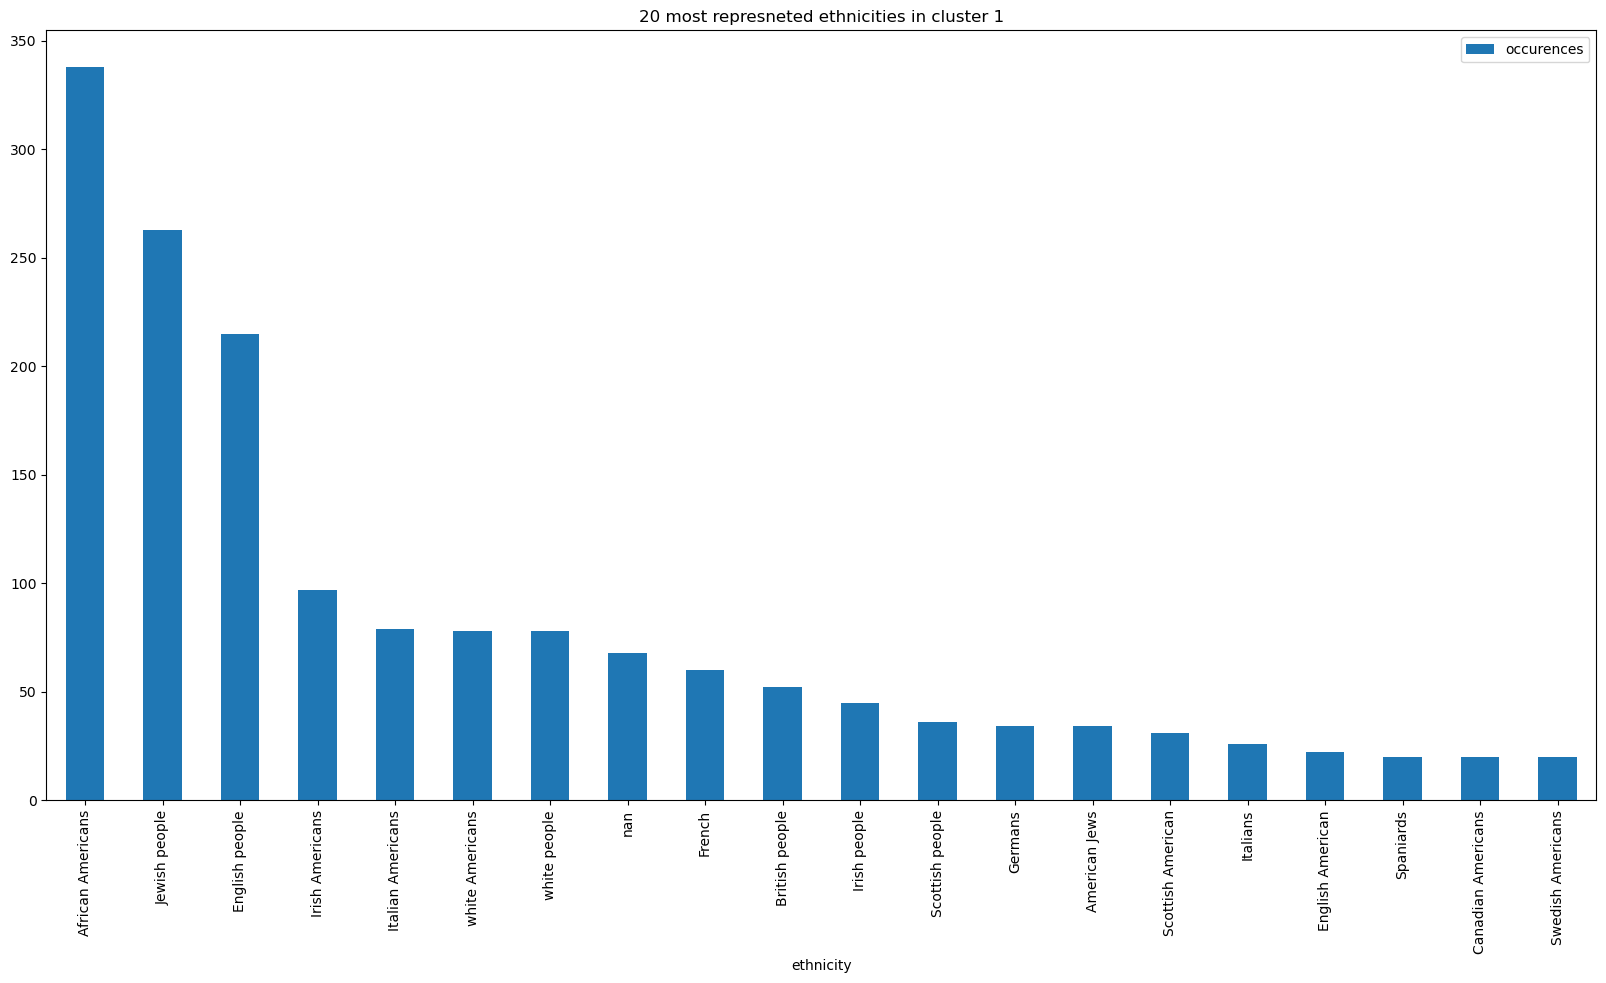

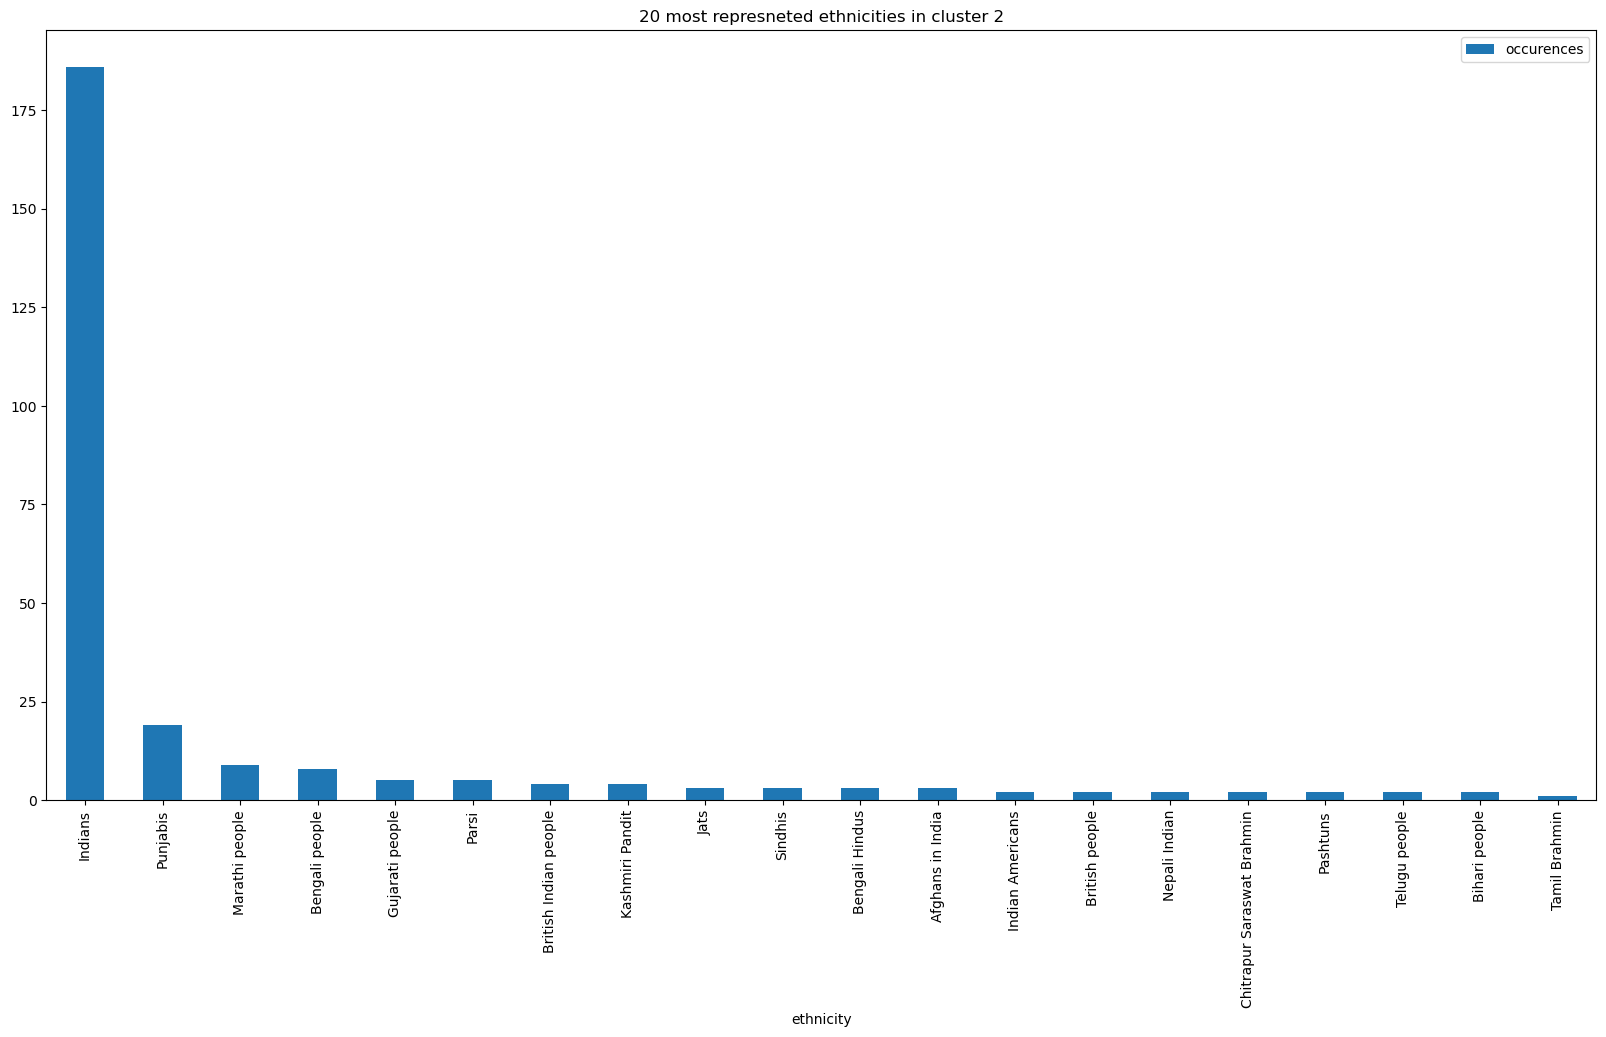

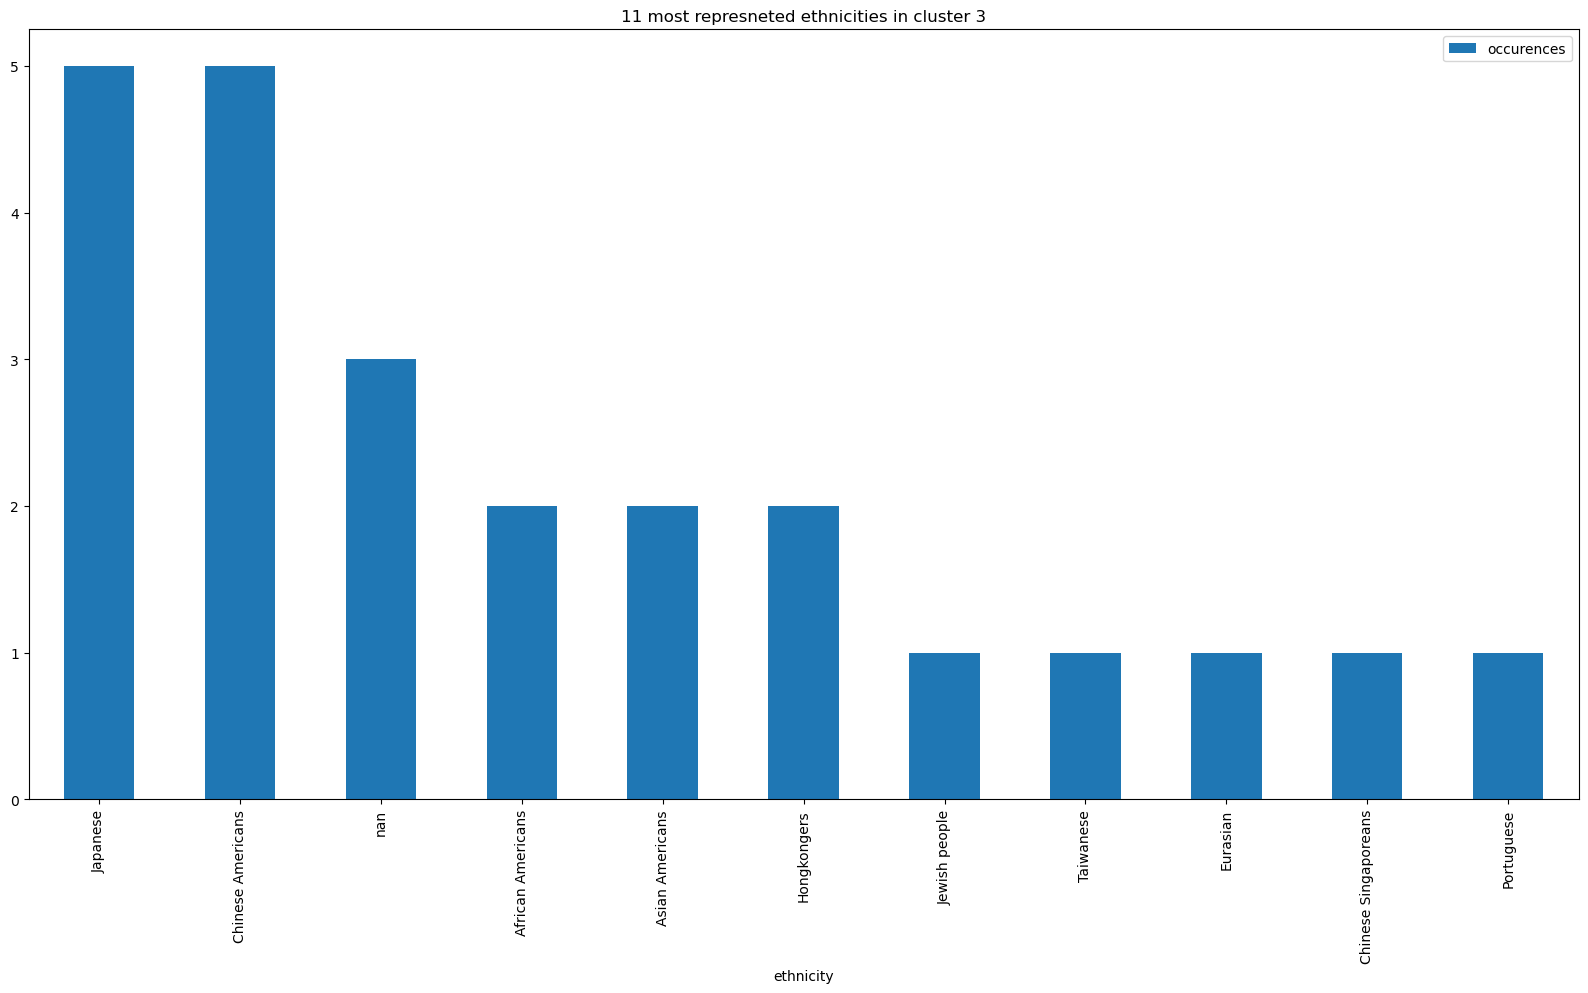

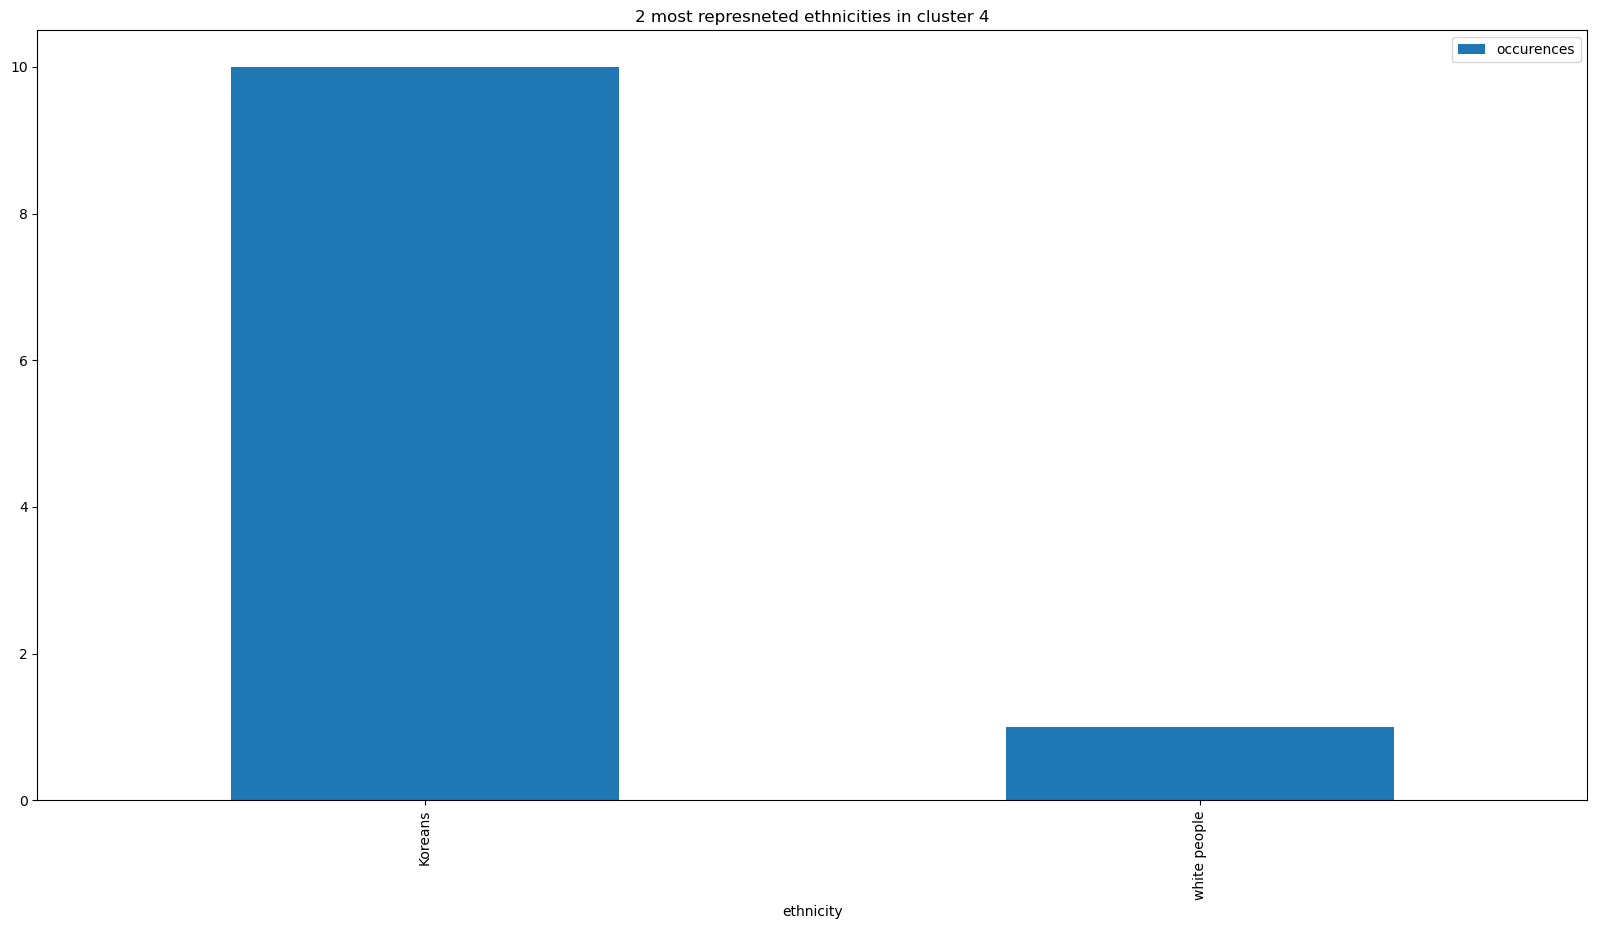

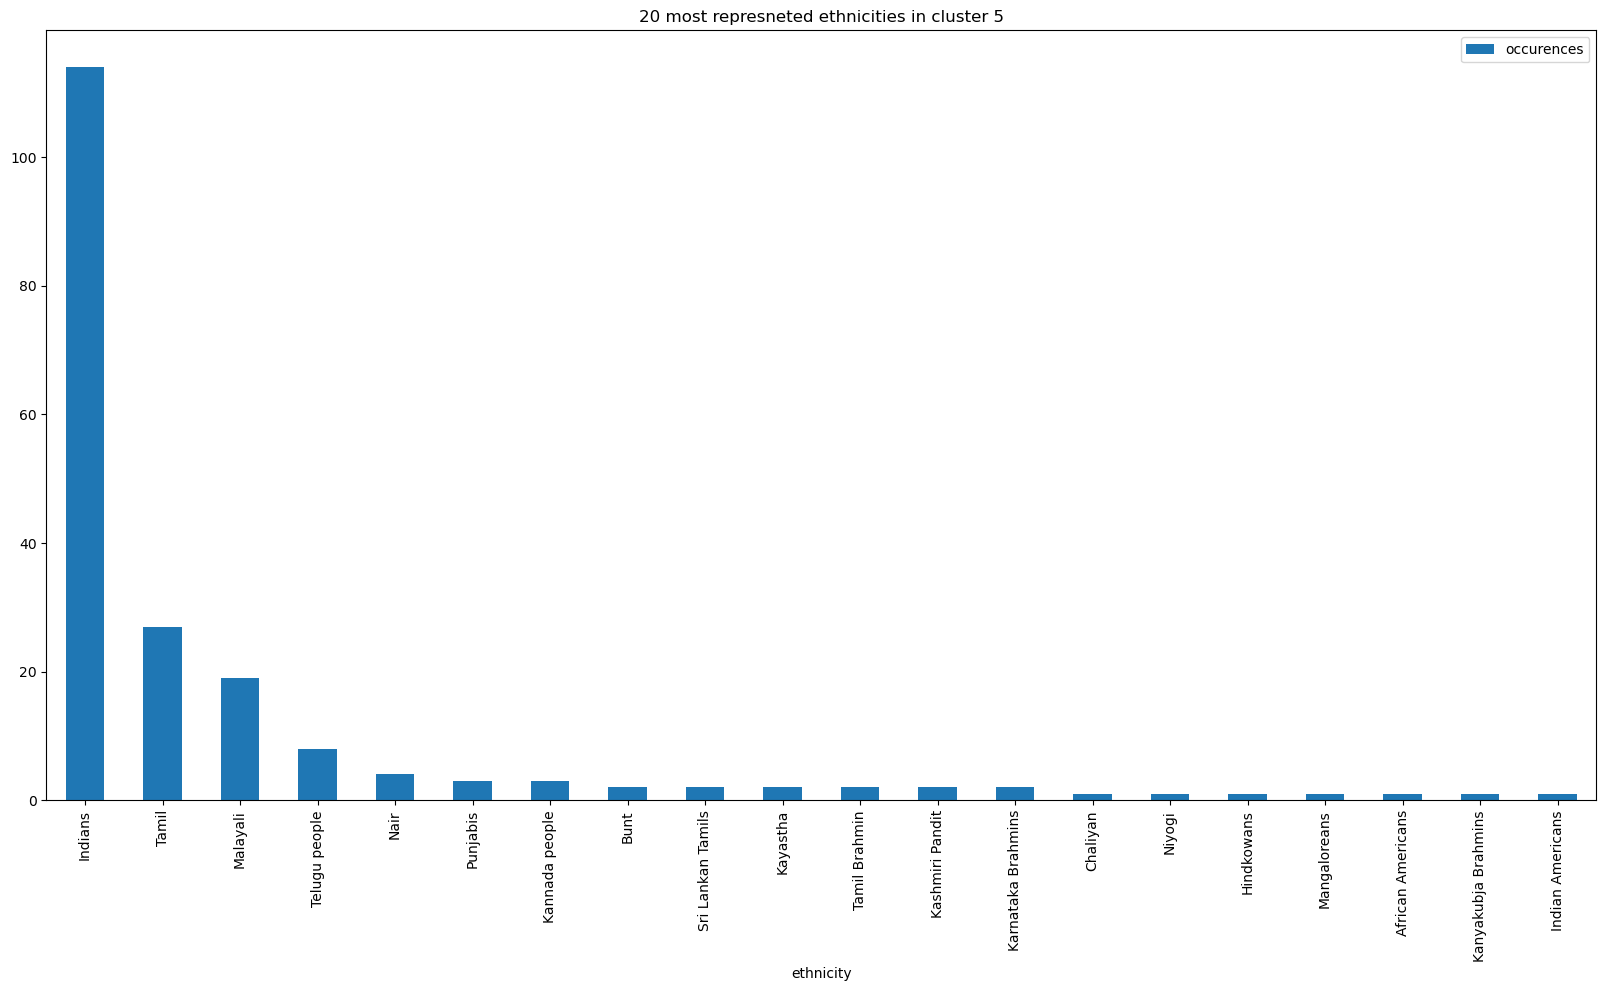

In [84]:

plot_eth((ethnicities1, 1), (ethnicities2, 2),
         (ethnicities3, 3), (ethnicities4, 4),(ethnicities5, 5) )


For the graphs, it think it suffice to write in plain text the main observation. I let them here but they are imo not very important due to the few numbers of ethnicities we have. (what is interesting though is the general trend of ethnicities). Especially the two cluster for india. They appear like they are one cluster one the graph but we see here that i might be two different industry. Unfortunately, this is not true for chinese and japanese industry, which is quite weird, so what should address this concern.

### Connections

In [85]:
graph = load_graph()

In [86]:
def get_con(cluster):
    cluster_co = {n: graph.nodes[n] for n in cluster.index}
    cluster_co = pd.DataFrame.from_dict(cluster_co, orient='index')
    cluster_co['cluster_id'] = cluster[cluster.index == cluster_co.index]['cluster_id']
    return cluster_co

In [87]:
cluster1_connections = get_con(cluster1)
cluster2_connections = get_con(cluster2)
cluster3_connections = get_con(cluster3)
cluster4_connections = get_con(cluster4)
cluster5_connections = get_con(cluster5)

In [88]:
clusters_co = pd.concat([cluster1_connections, cluster2_connections, cluster3_connections, cluster4_connections, cluster5_connections])

not sure if needed

In [89]:
print(cluster1_connections.aggregate({'num_connections' : ['sum']}) / len(cluster1))
print(cluster2_connections.aggregate({'num_connections' : ['sum']}) / len(cluster2))
print(cluster3_connections.aggregate({'num_connections' : ['sum']}) / len(cluster3))
print(cluster4_connections.aggregate({'num_connections' : ['sum']}) / len(cluster4))
print(cluster5_connections.aggregate({'num_connections' : ['sum']}) / len(cluster5))

     num_connections
sum        21.856828
     num_connections
sum        29.100258
     num_connections
sum         21.19032
     num_connections
sum        17.955263
     num_connections
sum        30.664172


In [90]:
def plot_connections(cluster):
    co = cluster.copy()
    co = co.sort_values(by='num_connections', ascending=True)
    
    sns.ecdfplot(data=co, x='num_connections', palette='viridis', hue='cluster_id')

    plt.yscale('log')   
    plt.xscale('log')     

    plt.title('ECDF of Connectivity within clusters')
    plt.xlabel('Number of connections within cluster')
    plt.ylabel('Proportion')

    #plt.savefig(RESULTS_PATH + 'outliers_top1%_connnectivity.png', bbox_inches='tight', dpi=500)

    plt.show()
    

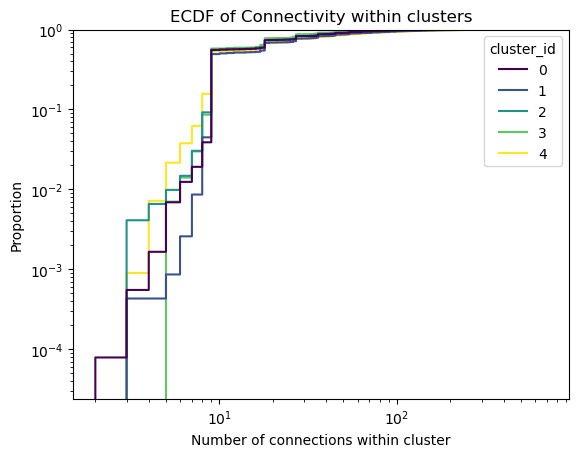

In [91]:
clusters_co = get_con(pd.concat([cluster1, cluster2, cluster3, cluster4, cluster5]))
plot_connections(clusters_co)

### Gender

In [92]:
percentage = (len(people) - len(people.gender.dropna()))/len(people)
print('There are {:.2%} of people with value for gender'.format(percentage))

There are 75.25% of people with value for gender


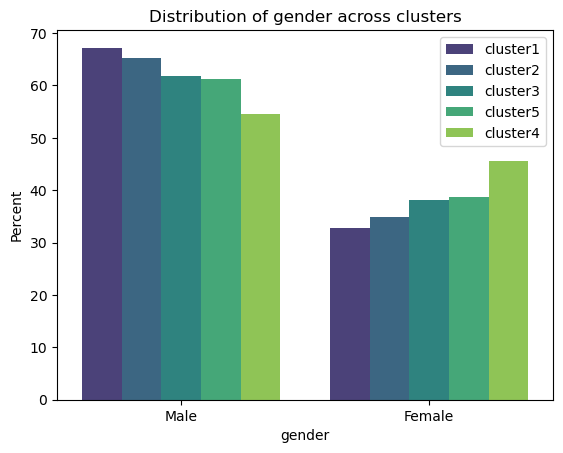

In [93]:
cluster1_gender = pd.DataFrame([j for l in cluster1.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster2_gender = pd.DataFrame([j for l in cluster2.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster3_gender = pd.DataFrame([j for l in cluster3.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster4_gender = pd.DataFrame([j for l in cluster4.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
cluster5_gender = pd.DataFrame([j for l in cluster5.gender.dropna().values for j in l], columns=['gender']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()



cluster1_gender['Cluster'] = 'cluster1'
cluster2_gender['Cluster'] = 'cluster2'
cluster3_gender['Cluster'] = 'cluster3'
cluster4_gender['Cluster'] = 'cluster4'
cluster5_gender['Cluster'] = 'cluster5'


# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([cluster1_gender, cluster2_gender, cluster3_gender, cluster4_gender, cluster5_gender]).sort_values(by='Percent', ascending=False)
#rename gender value to Male and Female in data dataframe 'gender'
data['gender'] = data['gender'].replace(['M'], 'Male')
data['gender'] = data['gender'].replace(['F'], 'Female')
sns.barplot(data=data, x='gender', y='Percent', hue='Cluster', palette='viridis')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of gender across clusters")
#rename x values
plt.show()


### for cluster within clusters

The oriinal graph was kinda engineered in a way to fit what we wanted, so it is difficult to have a reclustering of the graph.
It is imo not worth digging deeper into this, due to the nature of our data/graph to begin with. But the following code under 
can be used to tackle this task.

In [94]:
# Clusters node using optics
def optics_clustering(node_positions, min_samples, max_eps, xi, min_cluster_size):
    positions_array = np.array([position for position in node_positions.values()])
    clustering = OPTICS(min_samples=min_samples, max_eps=max_eps,
        xi=xi, min_cluster_size=min_cluster_size, n_jobs=10
        ).fit(positions_array)
    labels = clustering.labels_
    
    return {id:label for id, label in zip(node_positions.keys(), labels)}

In [95]:
position = load_positions()
res = optics_clustering(position, min_samples=15, max_eps=0.0029, xi=0.2, min_cluster_size=400)

In [96]:
subclusters = load_cluster_dbscan()
#make subclusters into a dataframe
subclusters = pd.DataFrame.from_dict(subclusters, orient='index', columns=['cluster'])


In [97]:
subclusters.nunique()

cluster    389
dtype: int64

In [98]:
#compare entry person_name_id of cluster with subclusters. If match, check cluster_id of subclusters, then add it to new dataframe with cluster_id and person_name_id
def get_subclusters(cluster):
	df = subclusters.copy()
	#keep only rows of df which index in cluster corresponding to index in subcluster,
	df = df.loc[df.index.isin(cluster.index)]
	return df
		


In [99]:
sc1 = get_subclusters(cluster1)
sc2 = get_subclusters(cluster2)
sc3 = get_subclusters(cluster3)
sc4 = get_subclusters(cluster4)
sc5 = get_subclusters(cluster5)
sc6 = get_subclusters(cluster_outlier)

In [100]:
connections = load_cluster_coefficients()